# Defining geometry of the domain 
## Using proteus.mprans.SpatialTools for two-phase flows

**SpatialTools:**<br />
documentation: http://proteustoolkit.org/api/proteus.SpatialTools.html <br />
source: https://github.com/erdc/proteus/blob/master/proteus/SpatialTools.py<br />

**mprans.SpatialTools** (multi-phase flow):<br />
documentation: http://proteustoolkit.org/api/proteus.mprans.SpatialTools.html<br />
source: https://github.com/erdc/proteus/blob/master/proteus/mprans/SpatialTools.py<br />


In [9]:
%matplotlib notebook
# general imports
from proteus import Domain
from proteus.mprans import SpatialTools as st
import numpy as np
from nbtools import plot_domain, plot_js

The domain is the class that will hold all the geometry defined below. 
Usually, the variable containing the Domain class that will be used for simulations must be called "domain" because the split operator will look specifically for this variable name.
The shapes, boundary conditions, barycenters, etc. are all automatically associated to the domain as long as the shapes were created with the domain class instance passed as an argument.

Firstly, the domain class instance must be defined and will be used to store the various geometries that the user defines.
We will create 2 domain (2D and 3D) to get an overview of the possible geometries

In [10]:
domain2D = Domain.PlanarStraightLineGraphDomain()
domain3D = Domain.PiecewiseLinearComplexDomain()

### General

In order to define a geometry, the following information must be passed:
 - vertices: list of point coordinates defining the geometry. e.g. `[[x1,y1],[x2,y2]]` in 2D or `[[x1,y1,z1],[x2,y2,z2]]` in 3D 
 - segments (2D only): list of list of indices linking 2 vertices. e.g. `[[0,1], [1,2]]`
 - facets (3D only): list of list of a list of indices from several vertices forming a closed area. Can be set clockwise or counterclockwise. e.g. `[[[0,1,2,3]],[[2,3,4,5,6]]]`
 - regions: list of coordinates.
 - vertexFlags, segmentFlags, facetFlags, regionFlags: list of integer determining boundary conditions. e.g. `[1,1,2,3,3,3]`
 - holes: list of coordinates (optional).
 - boundaryTags: dictionary of flags, e.g. `{1: 'left', 2: 'right', 3: 'top'}`

### Custom shapes

Defining a CustomShape is similar to defining a Domain from scratch (see the jupyter notebook tutorial Domain).
The main difference is that it needs a boundary tags dictionary (used for flagging elements), vertices, segments (or facets in 3D), and their respective flags that will be used for boundary conditions.

In [11]:
my_vertices = [[0., 0.], [2., 0.], [8., 0.], [10., 0.],
               [10., 5.], [8., 5.], [2., 5.], [0., 5.]]
my_segments = [[0, 1], [1, 2], [2, 3], [3, 4], 
               [4, 5], [5, 6], [6, 7], [7, 0],
               [1, 6], [2, 5]]

The number of entries in the boundaryTags dictionary gives the number of different boundary condition class instances on the shape. The values of the dictionary should always consist of a list of integers starting from 1 and incrementing by 1. The flags are used to tell which vertex/segment/facet gets which boundary condition.

In [12]:
# boundary tags dictionary
bt = {'bottom': 1, 'right': 2, 'top': 3, 'left': 4, 'sponge': 5}

# the number of flags must be the same as the number of vertices defined above
my_vertexFlags = [bt['bottom'], bt['bottom'], bt['bottom'], bt['bottom'],
                  bt['top'], bt['top'], bt['top'], bt['top'],
                  bt['sponge'], bt['sponge']]

# flags can also be defined directly with the values in the dictionary instead of using the tags
my_segmentFlags = [1, 1, 1, 2, 3, 3, 3, 4, 5, 5]

Regions are defined by giving the coordinates of a point within an area enclosed by segments/facets. It does not matter where the point lies within the region as long as it is inside a space enclosed by segments (or facets).

Region flags have no link with the boundary tag dictionary defined above and will be used for regional boundary conditions (e.g relaxation zones).

In [13]:
my_regions = [[1., 1.], [5., 1.], [9., 1.]]
my_regionFlags = [2, 1, 3]

Create the custom shape. The domain must always be passed in order to add the geometry to the domain's shape list

<IPython.core.display.Javascript object>


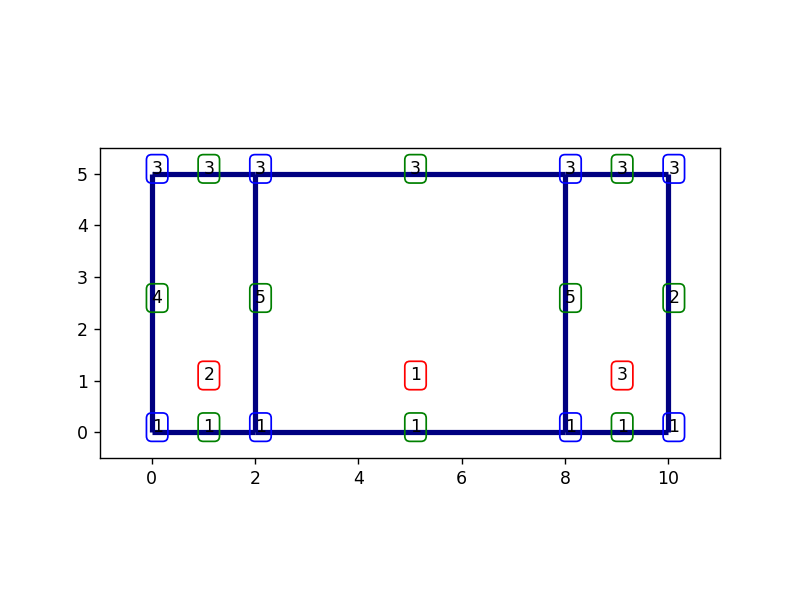

In [14]:
domain2D = Domain.PlanarStraightLineGraphDomain()
my_custom = st.CustomShape(domain2D, boundaryTags=bt, 
                           vertices=my_vertices, vertexFlags=my_vertexFlags,
                           segments=my_segments, segmentFlags=my_segmentFlags, 
                           regions=my_regions, regionFlags=my_regionFlags)
plot_domain(domain2D, regionFlags='local', vertexFlags='local', segmentFlags='local')

### Predefined Shapes

The available shape classes from proteus.mprans.SpatialTools: 
- Rectangle 
- Circle
- Cuboid
- Cylinder
- Tank2D (mprans)
- Tank3D (mprans)
- ShapeSTL

...

The same geometry as the one defined at the beginning of the notebook can be defined directly and be modified easily with the "Tank2D" class in SpatialTools. 

<IPython.core.display.Javascript object>


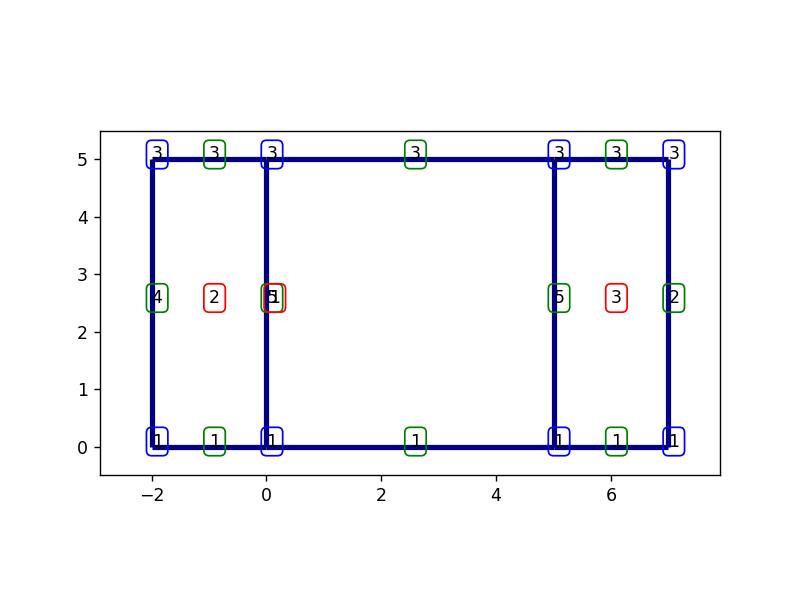

In [19]:
domain2D = Domain.PlanarStraightLineGraphDomain()
my_tank = st.Tank2D(domain2D, dim=[5., 5.])
my_tank.setSponge(x_n=2., x_p=2.)
plot_domain(domain2D, regionFlags='local', vertexFlags='local', segmentFlags='local')

Same as above but adding other shapes in the tank

<IPython.core.display.Javascript object>


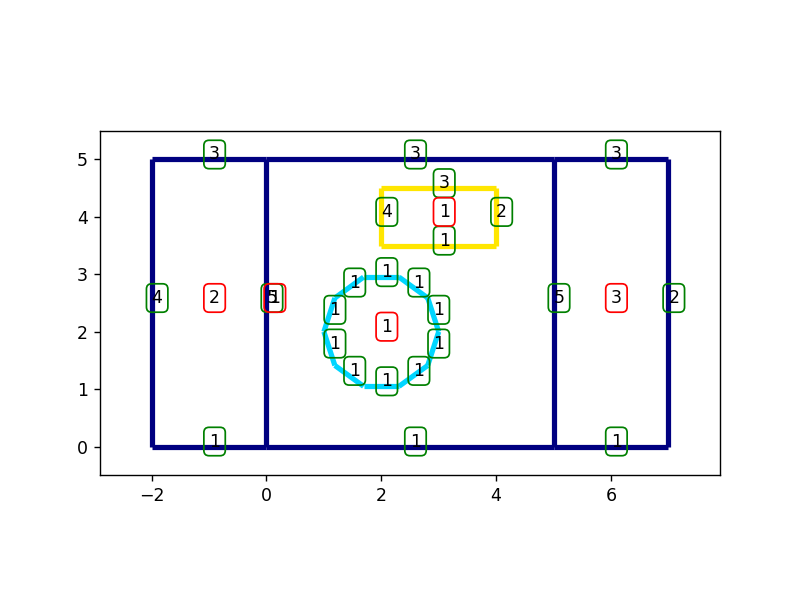

In [26]:
domain2D = Domain.PlanarStraightLineGraphDomain()
# tank
my_tank = st.Tank2D(domain2D, dim=[5., 5.])
my_tank.setSponge(x_n=2., x_p=2.)
# circle
my_circle = st.Circle(domain2D, radius=1, coords=[2., 2.], nPoints=10, barycenter=np.zeros(3))
my_circle.setHoles([[2., 2.]])  # adding a hole so the inside of the circle will not be meshed by mesher "triangle"
# rectangle
my_rect = st.Rectangle(domain2D, dim=[2.,1.], coords=[3., 4.])
my_rect.setHoles([[2., 2.]])  # adding a hole so the inside of the circle will not be meshed by mesher "triangle"
# assemble the domain: always after all shapes have been defined
st.assembleDomain(domain2D)

plot_domain(domain2D, vertexFlags=None, regionFlags='local', segmentFlags='local')

## Transforming Geometries

Shapes can be easily moved and rotated. This will affect: vertices, regions, holes, coords (if not None), barycenters for rotation and translation as well as local coordinate system and boundary orientations for rotation only.

*note: for rotation, if the pivot point is not passed as an argument, the shape will rotate around its barycenter (if defined, otherwise around the origin [0., 0.])*

In [27]:
my_rect.rotate(np.pi/12., pivot=my_rect.coords)
my_circle.translate([-0.5, -0.2])

#my_cuboid.rotate(np.pi/6., pivot=[2., 2., 2.], axis=[1., 1., 0.])

# for setPosition(), the barycenter must first be set.
# we will use the "coords" variable of the predefined shape (center of rectangle)
#my_rectangle.setBarycenter(my_rectangle.coords)
#my_rectangle.setPosition([4., 2.])

<IPython.core.display.Javascript object>


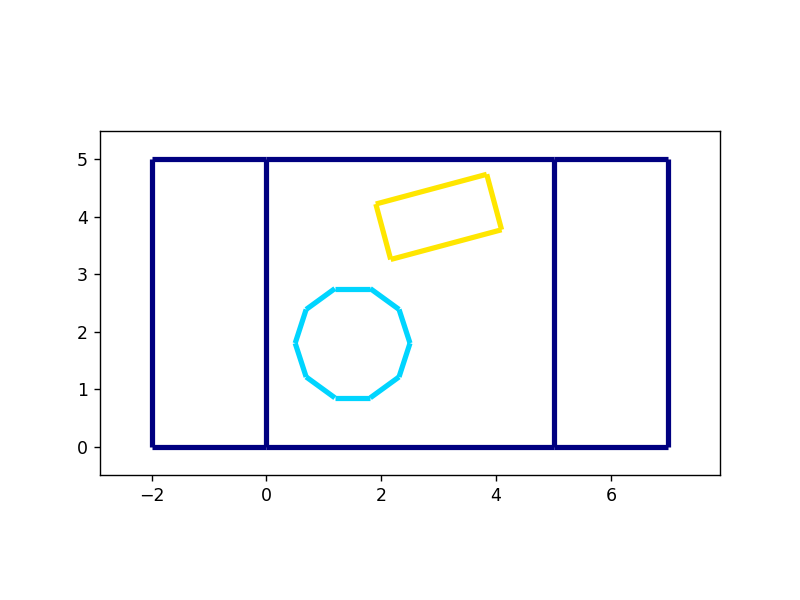

In [28]:
plot_domain(domain2D, vertexFlags=None, segmentFlags=None, regionFlags=None)

### Assembling the domain

The domain should be assembled after all geometries as well as their auxiliary variables have been defined, including absorption/generation/porous zones which a regional boundary conditions (see BoundaryConditions tutorial).

<IPython.core.display.Javascript object>


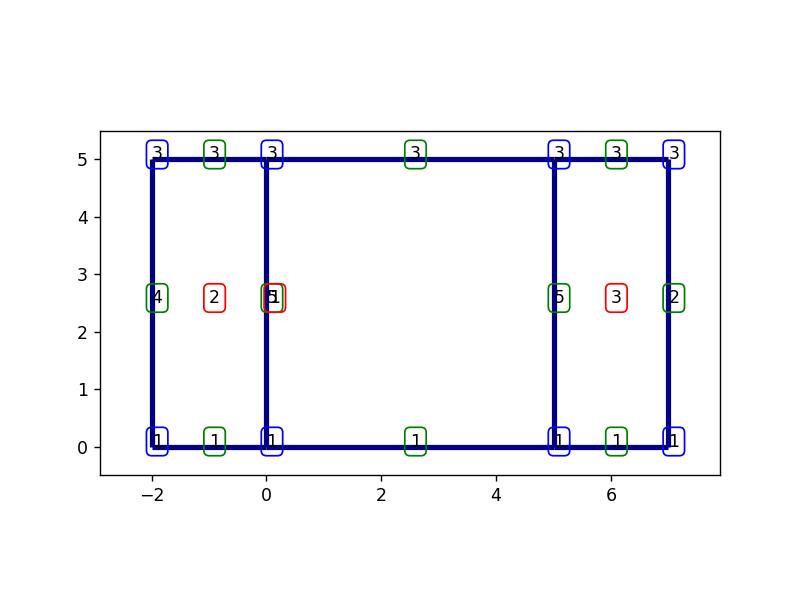

In [21]:
plot_domain(domain2D, vertexFlags='local', segmentFlags='local', regionFlags='local')

<IPython.core.display.Javascript object>


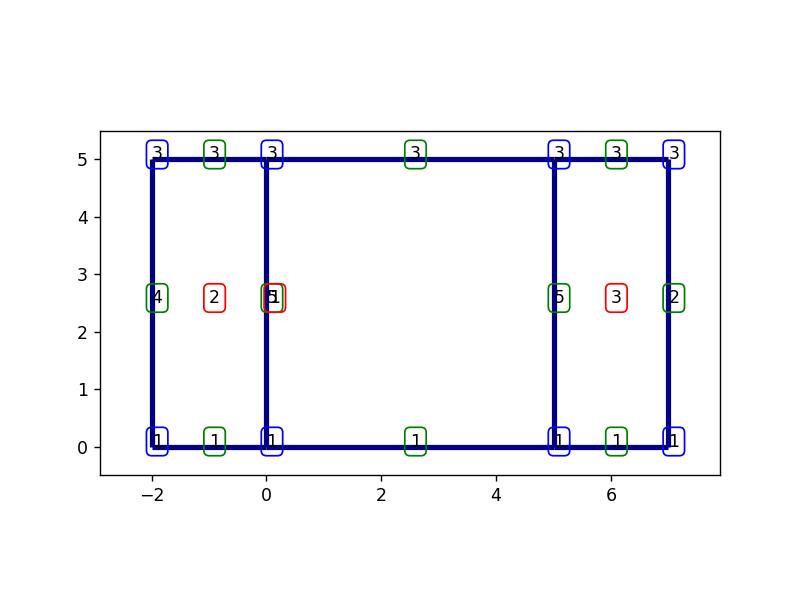

In [22]:
st.assembleDomain(domain2D)

plot_domain(domain2D, vertexFlags='global', segmentFlags='global', regionFlags='global')

In [ ]:
'Segment flags'
for i, shape in enumerate(domain2D.shape_list):
    print('shape '+str(i+1)+':', shape.segmentFlags.tolist())
print('domain', domain2D.segmentFlags)
print('number of boundary conditions:',len(domain2D.bc))